<a href="https://colab.research.google.com/github/UjvalN/FashionMNIST-Classification/blob/main/FashionMNIST_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import pandas as pd
import tqdm
from tqdm.notebook import tqdm
import timeit
from timeit import default_timer as timer

In [25]:
# Importing helper functions.
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("Already exists.")
else:
  print("Downloading helper_functions.py...")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)
  print("Done.")

Already exists.


In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"

train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

(-0.5, 27.5, 27.5, -0.5)

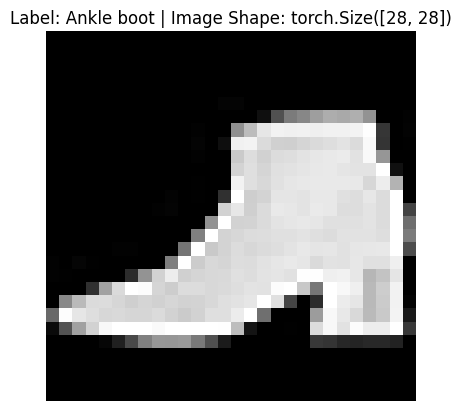

In [27]:
# Get a random sample from the dataset and visualize
import random

idx = random.randint(0, 10001)
test_image, test_label = test_data[idx][0].squeeze(), test_data[idx][1]
class_names = train_data.classes

plt.imshow(test_image, cmap="gray")
plt.title(f"Label: {class_names[test_label]} | Image Shape: {test_image.shape}")
plt.axis(False)

In [28]:
# Dataloaders
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [29]:
print(f"Train Dataloader: {len(train_dataloader)},  Batches of {BATCH_SIZE}")
print(f"Test Dataloader: {len(test_dataloader)},  Batches of {BATCH_SIZE}")

Train Dataloader: 1875,  Batches of 32
Test Dataloader: 313,  Batches of 32


In [30]:
# Keep track of which batch we are on
batch = 0

In [31]:
# Get a single batch and iterate
train_features_batch, train_labels_batch = next(iter(train_dataloader))
batch+=1

32
32


Text(0.5, 1.0, 'Batch: 1 | Label: Pullover | Image shape: torch.Size([1, 28, 28])')

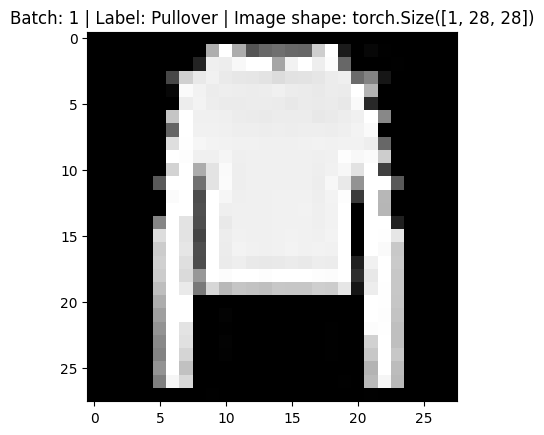

In [32]:
# Checking the lengths of the batch
print(len(train_features_batch))
print(len(train_labels_batch))

# Again, check if this works by visualizing
index = 10
plt.imshow(train_features_batch[index].squeeze(), cmap="gray")
plt.title(f"Batch: {batch} | Label: {class_names[train_labels_batch[index]]} | Image shape: {train_features_batch[0].shape}")

In [33]:
# TinyVGG Model
class TinyVGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU()
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
    )

    self.conv_block_4 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f"Output shape of conv_block_1: {x.shape}")
    x = self.conv_block_2(x)
    # print(f"Output shape of conv_block_2: {x.shape}")
    x = self.conv_block_3(x)
    # print(f"Output shape of conv_block_3: {x.shape}")
    x = self.conv_block_4(x)
    # print(f"Output shape of conv_block_4: {x.shape}")
    x = self.classifier(x)
    # print(f"Output shape of classifier: {x.shape}")
    return x

In [34]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

FashionMNIST_Model = TinyVGG(input_shape=1, # FashionMNIST is gray-scaled so only 1 input channel, if it was colored, like RGB, input shape would be 3.
                             hidden_units=50,
                             output_shape=len(class_names)).to(device)

In [35]:
# Grab an image and run a test forward pass
test_features_batch, test_labels_batch = next(iter(test_dataloader))

idx = 0
image, label = test_features_batch[idx].unsqueeze(0), test_labels_batch[idx]
FashionMNIST_Model(image.to(device))

tensor([[ 0.0426, -0.0284, -0.0133,  0.0122,  0.0033, -0.0021,  0.0254,  0.0212,
          0.0125, -0.0145]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [36]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=FashionMNIST_Model.parameters(),
                            lr=0.1)

In [43]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
FashionMNIST_Model.to(device)

start_time = timer()

EPOCHS = 10

for epoch in tqdm(range(EPOCHS)):
  print(f"Epoch:{epoch}\n------------")
  # TODO: train_step and test_step()

  # Training
  train_loss, train_acc = 0, 0
  for X, y in train_dataloader:
    X, y = X.to(device), y.to(device)
    FashionMNIST_Model.train()

    # Probabilities
    y_probs = FashionMNIST_Model(X)

    # Calculate the loss
    loss = loss_fn(y_probs, y)
    train_loss += loss

    # Accuracy
    accuracy = accuracy_fn(y, y_probs.argmax(dim=1))
    train_acc += accuracy

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  print(f"Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.2f}%")

  # Testing
  FashionMNIST_Model.eval()
  with torch.inference_mode():

    test_loss, test_acc = 0, 0

    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)
      y_probs = FashionMNIST_Model(X)

      loss = loss_fn(y_probs, y)
      test_loss += loss

      acc = accuracy_fn(y, y_probs.argmax(dim=1))
      test_acc += acc

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

    print(f"Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")

end_time = timer()
total_time = end_time - start_time
print(f"Train time on {device.upper()}: {total_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:0
------------
Train Loss: 0.24099 | Train Accuracy: 91.40%
Test Loss: 0.26080 | Test Accuracy: 90.55%
Epoch:1
------------
Train Loss: 0.22139 | Train Accuracy: 91.97%
Test Loss: 0.25127 | Test Accuracy: 90.90%
Epoch:2
------------
Train Loss: 0.20687 | Train Accuracy: 92.61%
Test Loss: 0.24459 | Test Accuracy: 91.21%
Epoch:3
------------
Train Loss: 0.19556 | Train Accuracy: 92.84%
Test Loss: 0.23940 | Test Accuracy: 91.41%
Epoch:4
------------
Train Loss: 0.18342 | Train Accuracy: 93.35%
Test Loss: 0.24465 | Test Accuracy: 91.66%
Epoch:5
------------
Train Loss: 0.17400 | Train Accuracy: 93.67%
Test Loss: 0.23978 | Test Accuracy: 91.67%
Epoch:6
------------
Train Loss: 0.16674 | Train Accuracy: 93.97%
Test Loss: 0.23800 | Test Accuracy: 91.63%
Epoch:7
------------
Train Loss: 0.15825 | Train Accuracy: 94.25%
Test Loss: 0.23590 | Test Accuracy: 92.06%
Epoch:8
------------
Train Loss: 0.14950 | Train Accuracy: 94.50%
Test Loss: 0.25334 | Test Accuracy: 91.44%
Epoch:9
-----------

In [38]:
# Evaluate the model

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device=device):
  loss, acc = 0, 0

  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X, y = X.to(device), y.to(device)

      y_probs = model(X)

      loss += loss_fn(y_probs, y)
      acc += accuracy_fn(y, y_probs.argmax(dim=1))

    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

model_results = eval_model(model=FashionMNIST_Model,
                           data_loader=test_dataloader,
                           loss_fn=loss_fn,
                           accuracy_fn=accuracy_fn,
                           device=device)

model_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'TinyVGG',
 'model_loss': 0.27619028091430664,
 'model_acc': 90.02595846645367}

In [39]:
# Visualize
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):

  model.to(device)
  pred_probs=[]

  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)

      pred_logit = model(sample)

      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

In [40]:
import random
# random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

In [41]:
pred_probs = make_predictions(model=FashionMNIST_Model,
                              data=test_samples)

pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 0, 7, 7, 5, 7, 1, 3, 4])

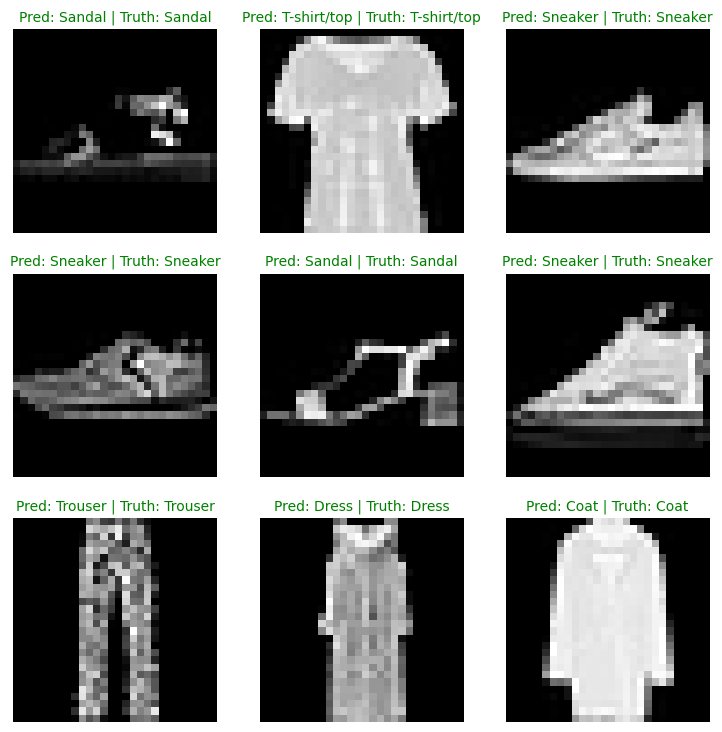

In [42]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")

  # Model predictions
  pred_label = class_names[pred_classes[i]]

  # Actual labels
  truth_label = class_names[test_labels[i]]

  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")

  plt.axis(False)